<a href="https://colab.research.google.com/github/Shubhangidharmik/Product-Recommendation-Engine/blob/main/Product_Recommendation_Engine_updated_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Build a recommender engine that reviews customer ratings and purchase history to recommend items and improve sales. </u></b>

### Amazon.com is one of the largest electronic commerce and cloud computing companies.

### Just a few Amazon related facts:

### They lost $4.8 million in August 2013, when their website went down for 40 mins. They hold the patent on 1-Click buying, and licenses it to Apple. Their Phoenix fulfilment centre is a massive 1.2 million square feet. Amazon relies heavily on a Recommendation engine that reviews customer ratings and purchase history to recommend items and improve sales.


### This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

### It contains

* ### the unique UserId (Customer Identification),
* ### the product ASIN (Amazon's unique product identification code for each product),
* ### Ratings (ranging from 1-5 based on customer satisfaction) and
* ### the Timestamp of the rating (in UNIX time)

### This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

### This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).


# **Import libraries**

In [ ]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 6.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630165 sha256=0e881a4f7175fd6a902372c5352b160d4a35000b92e9a82518f5934c6e0599e5
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import KNNBasic, SVD, NormalPredictor, KNNBaseline,KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, dataset, accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#columns = ['UserId', 'ProductId', 'Rating','Timestamp']
df = pd.read_csv('/content/drive/MyDrive/Capstone Projects/Product recommendation Engine/Copy of ratings_Beauty.csv')
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df.shape

(2023070, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


# **Data Cleaning**

In [ ]:
df.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [ ]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

**Dropping the "Timestamp" column**

In [ ]:
df = df.drop('Timestamp', axis=1)
#df = df.drop('timestamp',inplace= True, axis = 1)

In [ ]:
df.head(2)

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0


In [ ]:
df.isna().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

# **Exploratory Data Analysis**

In [ ]:
df['Rating'].value_counts()

5.0    1248721
4.0     307740
1.0     183784
3.0     169791
2.0     113034
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Rating of the product')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Frequency')

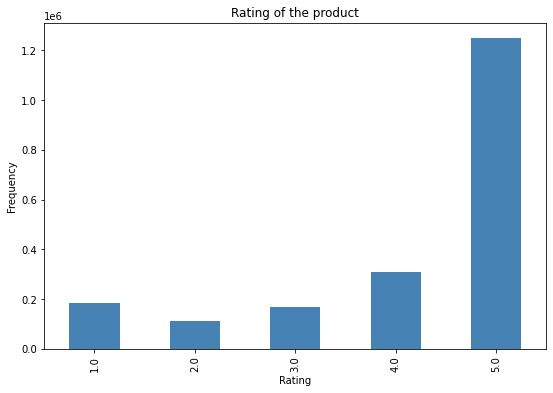

In [ ]:
counts = df['Rating'].value_counts().sort_index()
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
counts.plot.bar(ax = ax, color='steelblue')
ax.set_title('Rating of the product')
ax.set_xlabel('Rating') 
ax.set_ylabel("Frequency")
plt.show()

In [ ]:
df.UserId.value_counts()

A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
AFLE9ZCCERY6L       1
A2U2AW7L2BU1S       1
A2KNQZY2DU4H8I      1
A6J6SJ1063P79       1
A3MQDRRGC9070R      1
Name: UserId, Length: 1210271, dtype: int64

In [ ]:
print('Number of unique users', len(df['UserId'].unique()))

Number of unique users 1210271


In [ ]:
print('Number of unique products', len(df['ProductId'].unique()))

Number of unique products 249274


In [ ]:
print('Unique Ratings', df['Rating'].unique())

Unique Ratings [5. 3. 4. 1. 2.]


In [ ]:
min_ratings1 = df[(df['Rating'] < 2.0)]
print('Number of unique products rated low',len(min_ratings1['ProductId'].unique()))

Number of unique products rated low 66069


In [ ]:
max_ratings1 = df[df['Rating'] >= 4.0]
print('Number of unique products rated high',len(max_ratings1['ProductId'].unique()))

Number of unique products rated high 220746


In [ ]:
avg_rating_prod = df.groupby('ProductId').sum() / df.groupby('ProductId').count()
avg_rating_prod.drop('UserId', axis=1,inplace =True)

In [ ]:
print ('Top 10 highly rated products \n',avg_rating_prod.nlargest(10,'Rating'))

Top 10 highly rated products 
             Rating
ProductId         
0205616461     5.0
0762451459     5.0
1304139212     5.0
1304139220     5.0
130414089X     5.0
1304146537     5.0
130414674X     5.0
1304168522     5.0
1304174778     5.0
1304174867     5.0


In [ ]:
userID = df.groupby('UserId').count()

In [ ]:
top_user = userID[userID['Rating'] >= 50].index
top_user_ratings = df[df['UserId'].isin(top_user)]

In [ ]:
top_user_ratings.head()

,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
42,A22ZFXQE8AWPEP,1304482596,1.0
47,A22ZFXQE8AWPEP,1304482685,1.0
52,A22ZFXQE8AWPEP,1304495396,1.0
61,A22ZFXQE8AWPEP,1304511111,1.0


In [ ]:
top_user_ratings.sort_values(by='Rating', ascending=False).head()

,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
1779178,ACZ94JB8BFMJ9,B00A9MKPT0,5.0
1778023,A10G136JEISLVR,B00A8I8AVA,5.0
1778730,A1Z54EM24Y40LL,B00A8S6HM4,5.0
1778920,A2K7V3G4598QRF,B00A93VUEI,5.0


In [ ]:
prod = df.groupby('ProductId').count()

# **The users who has given 50 or more number of ratings**

In [ ]:
top_prod = prod[prod['Rating'] >= 50].index
top_ratings = top_user_ratings[top_user_ratings['ProductId'].isin(top_prod)]

In [ ]:
top_ratings.sort_values(by='Rating', ascending=False).head()

,UserId,ProductId,Rating
1717,A2FQZKL2KIZACO,9790790961,5.0
1436380,A2S7YBFPZX1IGQ,B005OZW3ZG,5.0
1435690,A1APERZNMEU8PW,B005OZGDO8,5.0
1435806,A1YVJ2CLK0L2WR,B005OZH88I,5.0
1435808,ADMPGWBF0BC9W,B005OZH88I,5.0


# **Split the data into train and test set**

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(top_ratings, test_size = 0.30, random_state=0)

In [ ]:
train_data.head()

,UserId,ProductId,Rating
1812795,A1UQBFCERIP7VJ,B00AWLB9G6,5.0
1786137,A1UMSB7LAW0RIR,B00AE07CT8,2.0
84157,A2CHH5P055A0KL,B00027D8IC,4.0
486007,A10G136JEISLVR,B000YJ2SKM,5.0
1098154,A27FP0S5QH7GNE,B003TMO3EU,3.0


In [ ]:
test_data.head()

,UserId,ProductId,Rating
1635236,ACZ94JB8BFMJ9,B0084A5PSK,5.0
1804057,ARYSDAZNRXN6G,B00AQ8NIC8,2.0
1786908,A3J029KBNG5MNP,B00AE07FXQ,4.0
932797,A2V5R832QCSOMX,B002UUT38I,5.0
97672,AKMEY1BSHSDG7,B0002RPTX4,5.0


# **Popularity Recommender model**

In [ ]:
#Building the recommendations based filtering model.
train_data_groupby = train_data.groupby('ProductId').mean().reset_index()

In [ ]:
train_data_groupby.head()

,ProductId,Rating
0,9790790961,5.000000
1,B00004TMFE,2.000000
2,B00004U9UY,4.333333
3,B000050B6U,2.500000
4,B000050B75,5.000000


In [ ]:
train_data_sort = train_data_groupby.sort_values(['Rating', 'ProductId'], ascending=False)
train_data_sort.head()

,ProductId,Rating
3203,B00KHH2VOY,5.0
3202,B00KHGIK54,5.0
3201,B00KH6F6TM,5.0
3200,B00KGDRCZW,5.0
3199,B00KD73PBQ,5.0


In [ ]:
train_data.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head(10) 

ProductId
B009FKNGGQ    40
B00AE0790U    38
B00AWLB9I4    33
B009FKNGRA    33
B000AO2NXS    32
B00AWLB9G6    32
B00AO4EBOI    31
B00AE078TM    31
B007RTR9DS    31
B00AAIOP44    29
Name: Rating, dtype: int64

In [ ]:
ratings_mean = pd.DataFrame(train_data.groupby('ProductId')['Rating'].mean()) 

In [ ]:
ratings_mean['rating_counts'] = pd.DataFrame(train_data.groupby('ProductId')['Rating'].count())  
ratings_mean.head()

,Rating,rating_counts
ProductId,,
9790790961,5.000000,2
B00004TMFE,2.000000,1
B00004U9UY,4.333333,3
B000050B6U,2.500000,2
B000050B75,5.000000,1


In [ ]:
columns = ['UserId', 'ProductId', 'Rating', 'Timestamp']
df = pd.read_csv('/content/drive/MyDrive/Capstone Projects/Product recommendation Engine/Copy of ratings_Beauty.csv', names=columns)

In [ ]:
pred = test_data[['UserId', 'ProductId', 'Rating']]

In [ ]:
pred.rename(columns = {'Rating' : 'true_rating'}, inplace=True)

In [ ]:
pred = pred.merge(train_data_sort, left_on='ProductId', right_on = 'ProductId')

In [ ]:
pred.head(3)

In [ ]:
pred.rename(columns = {'ratings' : 'predicted_ratings'}, inplace = True)

In [ ]:
pred.head()

,UserId,ProductId,true_rating,Rating
0,ACZ94JB8BFMJ9,B0084A5PSK,5.0,3.75
1,A2LAS014NSRW72,B0084A5PSK,5.0,3.75
2,A2OCDK0BOW6UCY,B0084A5PSK,5.0,3.75
3,ARYSDAZNRXN6G,B00AQ8NIC8,2.0,3.00
4,A1047EDJ84IMAS,B00AQ8NIC8,4.0,3.00


In [ ]:
import sklearn.metrics as metric
from math import sqrt
MSE = metric.mean_squared_error(pred['true_rating'], pred['Rating'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.2043280085727588


# **Collaborative Filtering model**

In [ ]:
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [ ]:
#reader = Reader(rating_scale=(0.5, 5.0))
reader = Reader(rating_scale=(0,5))

In [ ]:
data = Dataset.load_from_df(top_ratings[['UserId', 'ProductId', 'Rating']],reader)

In [ ]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.3,random_state=0)

In [ ]:
knn = KNNWithMeans(k=10, min_k=6, sim_options={'name': 'pearson_baseline', 'user_based': True})
knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


**Single Value Decomposition**

In [ ]:
svd = SVD(n_factors=50,reg_all=0.02)
svd.fit(trainset)

In [ ]:
# RMSE for popularity recommender model
MSE = metric.mean_squared_error(pred['true_rating'], pred['Rating'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.2043280085727588


In [ ]:
print(len(testset))
type(testset)

4116


list

In [ ]:
# Evalution by knn
test_pred = knn.test(testset)
test_pred[0]

Prediction(uid='A25C2M3QF9G7OQ', iid='B009YSSLAU', r_ui=4.0, est=4.516699820834101, details={'actual_k': 10, 'was_impossible': False})

In [ ]:
# calculate RMSE
accuracy.rmse(test_pred) #range of value of error

RMSE: 1.0561


1.0561184327784499

In [ ]:
# Evaluation by svd
test_pred = svd.test(testset)

In [ ]:
# calcuate RMSE
accuracy.rmse(test_pred)

RMSE: 1.0095


1.0095298180309347

**Hyperparameter tuning**

In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [5,10,15], "reg_all":[0.01,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [ ]:
gs.fit(data)

In [ ]:
# best parameters
gs.best_params

{'rmse': {'n_factors': 5, 'reg_all': 0.01}}

In [ ]:
# for prediction
gs.test(testset)
accuracy.rmse(gs.test(testset))

[Prediction(uid='A25C2M3QF9G7OQ', iid='B009YSSLAU', r_ui=4.0, est=4.513547119144992, details={'was_impossible': False}),
 Prediction(uid='AY3D7DG5L5WCK', iid='B00GTBZHCA', r_ui=5.0, est=4.841854695611507, details={'was_impossible': False}),
 Prediction(uid='A2DPYMNI2HCIOI', iid='B00AE078YM', r_ui=4.0, est=2.920112533152867, details={'was_impossible': False}),
 Prediction(uid='A2Y4S4CNGKF21S', iid='B001H54SQ4', r_ui=5.0, est=3.653401613612377, details={'was_impossible': False}),
 Prediction(uid='AYB4ELCS5AM8P', iid='B00GTC1HCI', r_ui=5.0, est=4.577660780596028, details={'was_impossible': False}),
 Prediction(uid='A3GPAR4H5Y5OU8', iid='B000GUN98O', r_ui=4.0, est=4.100858965184776, details={'was_impossible': False}),
 Prediction(uid='A3IOCPLIMYDBCD', iid='B003V265QW', r_ui=1.0, est=3.6698062426145626, details={'was_impossible': False}),
 Prediction(uid='ALNFHVS3SC4FV', iid='B0034F9KEU', r_ui=5.0, est=3.901711722519296, details={'was_impossible': False}),
 Prediction(uid='AQY5XBYSENNZQ', i

RMSE: 0.8961


0.8960899480078692

# **Top 5 recommendations**

In [ ]:
from collections import defaultdict
def get_top_n(predictions, n=5):
  
    # the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # sorting the predictions.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(test_pred, n=5)

In [ ]:
# recommended items for user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A25C2M3QF9G7OQ ['B008VSYO5A', 'B00HSNWZKU', 'B00AO4EMKQ', 'B00HSNWXVQ', 'B006L6A06Q']
AY3D7DG5L5WCK ['B00A0J09C0', 'B00GTBZHUW', 'B00AWLB9G6', 'B00AWLB9I4', 'B00GTBZHCA']
A2DPYMNI2HCIOI ['B00014D5O8', 'B008RVYJS8', 'B0002VQ0WO', 'B0014AX89K', 'B008U2Y9BQ']
A2Y4S4CNGKF21S ['B00021B8L2', 'B003JTA1IU', 'B0030GFXMQ', 'B003I6O5RC', 'B000C1W6TK']
AYB4ELCS5AM8P ['B008VSYO5A', 'B004GIM68G', 'B001ECQ4JE', 'B00A0J084Y', 'B00AE07B9O']
A3GPAR4H5Y5OU8 ['B001ECQ4JE', 'B000GUN98O', 'B0030O3VRW', 'B001JQLNNC', 'B003WN1ELQ']
A3IOCPLIMYDBCD ['B007E0FQ1W', 'B004YZMKKU', 'B009FKNGRA', 'B001GIOW3G', 'B000F37UNM']
ALNFHVS3SC4FV ['B004Z209HS', 'B00DCNBST4', 'B001ECQ4YO', 'B000AO2NXS', 'B00HSNWZKU']
AQY5XBYSENNZQ ['B006L6A06Q', 'B00GTBZHUW', 'B001U0ONNY', 'B00GYB17TC', 'B00AE0790U']
A3091RP0SPZLMN ['B00AE07FUE', 'B00ALV8EJM', 'B00AE07CTI', 'B00GTC02LA', 'B002MO3CG6']
A3AZI828WJN1CD ['B00A0IWRRG', 'B007RTR8UC', 'B009G0E19Q', 'B00004U9UY', 'B00AO4EBOI']
A2XKJ1KX6XUHYP ['B000I5KCIW', 'B0037AO682', 'B002CML1XE', 

# **Conclusion**

1. The Popularity-based recommender system is a non-personalised recommender system 

2. Build Popularity Recommender model and found the RMSE value for Popularity Recommender model as 1.091 

3. The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

4. Build Collaborative Filtering model.The RMSE value for Collaborative Filtering model, by KNNWithMeans is 0.9941 and after SVD RMSE is 0.896

5. Between RMSE of Popularity and Collaborative filtering , Collaborative fitering is better with 0.896 scores.